# Problem 1: Finding the Optimal k and Bootstrap Iterations

In this task, you will use the **K-Nearest Neighbors (KNN)** classifier to classify handwritten digits from the **MNIST dataset**. The goal is to determine:
1. The optimal number of neighbors (k) for the KNN classifier.
2. The optimal number of bootstrap iterations needed to confidently estimate the model’s accuracy.

## Task Breakdown

1. **Download and preprocess the MNIST dataset** (use 10% of the dataset for faster experimentation).
2. **Implement bootstrap resampling** to evaluate the KNN classifier for various values of k.
3. Experiment with **different numbers of bootstrap iterations**.
4. **Determine the optimal values of k** and the minimum number of bootstrap iterations required for a confident result.

## Steps to Follow

1. **Preprocess the MNIST dataset**:
   - Normalize the pixel values (e.g., divide by 255 to scale between 0 and 1).
   - Select a random 10% subset of the dataset.

2. **KNN Classifier**:
   - Use the `KNeighborsClassifier` from `sklearn.neighbors`.
   - Iterate over different values of k, specifically $k = 1, 2, \dots, 10$.

3. **Bootstrap Resampling**:
   - For each value of k, perform several bootstrap iterations:
     - Resample the entire dataset with replacement to create a training set.
     - Train the KNN model on the resampled data.
     - Test the model on the remaining data points (out-of-bag data).
     - Compute and store the accuracy on the out-of-bag data for each iteration.

4. **Determine Optimal k and Bootstrap Iterations**:
   - Experiment with different numbers of bootstrap iterations (e.g., try 1, 2, 11, 22, 44, 88, etc.).
   - Calculate the mean accuracy across bootstrap iterations for each k.
   - Determine the optimal k and the number of iterations required for a stable estimate.

5. **Plot**:
   - Plot the mean accuracy for each value of k.
   - Include another plot showing how the mean accuracy stabilizes with increasing bootstrap iterations.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sklearn

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# randomize data (but keep the label)
np.random.seed(101)
randomize = np.arange(len(x_train))
np.random.shuffle(randomize)
x_train = x_train[randomize]
y_train = y_train[randomize]

randomize = np.arange(len(x_test))
np.random.shuffle(randomize)
x_test = x_test[randomize]
y_test = y_test[randomize]

# trim, change shape to 28*28 and convert to [0, 1]
# x_train, _, y_train, _ = sklearn.model_selection.train_test_split(x_train, y_train, test_size=0.1, random_state=101)
# x_test, _, y_test, _ = sklearn.model_selection.train_test_split(x_test, y_test, test_size=0.1, random_state=101)

x_train = x_train[:6000]
y_train = y_train[:6000]

x_test = x_test[:1000]
y_test = y_test[:1000]

x_train = x_train.reshape((6000, 28*28))
x_train = x_train.astype("float32") / 255.

x_test = x_test.reshape((1000, 28*28))
x_test = x_test.astype("float32") / 255.

In [4]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from concurrent.futures import ThreadPoolExecutor, as_completed


def bootstrap_knn_accuracy(x, y, k, n_iterations):
    # oob = out of bag = not in the bootstrap sample
    oob_accuracies = []
    for _ in range(n_iterations):
        # bootstrap resample
        indices = np.random.choice(len(x), size=len(x), replace=True)
        x_resampled, y_resampled = x[indices], y[indices]
        oob_indices = np.setdiff1d(np.arange(len(x)), indices)
        x_oob, y_oob = x[oob_indices], y[oob_indices]
        
        # train and evaluate KNN
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_resampled, y_resampled)
        y_pred = knn.predict(x_oob)
        oob_accuracies.append(metrics.accuracy_score(y_oob, y_pred))
    
    return np.mean(oob_accuracies)


In [5]:
# determine optimal k and bootstrap iterations
k_values = range(1, 11)
iterations = [1, 2, 11, 22, 44, 88]
mean_accuracies = {k: [] for k in k_values}

for k in k_values:
    for n_iter in iterations:
        mean_acc = bootstrap_knn_accuracy(x_train, y_train, k, n_iter)
        mean_accuracies[k].append(mean_acc)


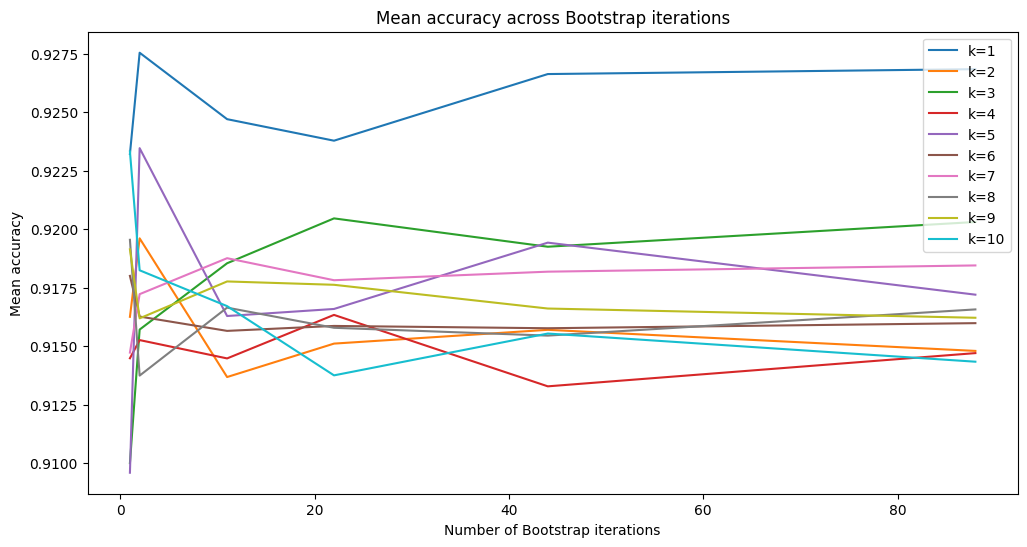

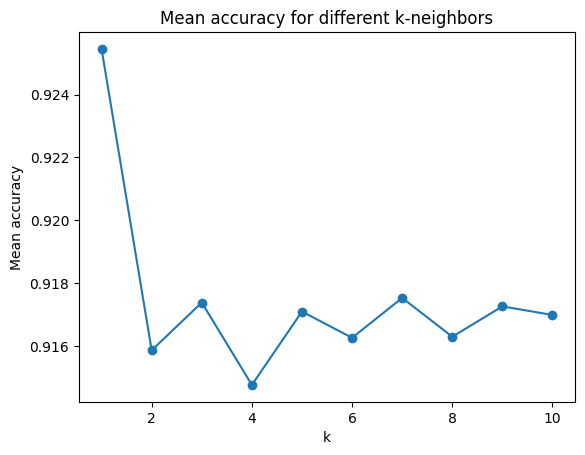

In [12]:
# plot
plt.figure(figsize=(12, 6))
for k in k_values:
    plt.plot(iterations, mean_accuracies[k], label=f'k={k}')
plt.xlabel('Number of Bootstrap iterations')
plt.ylabel('Mean accuracy')
plt.legend()
plt.title('Mean accuracy across Bootstrap iterations')
plt.show()

# accuracy vs k-neighbors
accuracies_k = [np.mean(mean_accuracies[k]) for k in k_values]
plt.figure()
plt.plot(k_values, accuracies_k, marker='o')
plt.xlabel('k')
plt.ylabel('Mean accuracy')
plt.title('Mean accuracy for different k-neighbors')
plt.show()

In [13]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.95
